<a href="https://colab.research.google.com/github/ShreyaVerma7/Algo/blob/master/StockPrediction_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import math
import numpy as np
import seaborn as sns
from sklearn import preprocessing

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y.%m.%d %H:%M:%S')

Reading available data and loading it into a pandas Dataframe

In [5]:
from google.colab import files
uploaded = files.upload()

#Selecting from among stock prediction files different files

fl = ['AUDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv','USDCHF_4 Hours_Ask_2003.05.04_2020.03.12.csv','EURUSD_4 Hours_Ask_2003.05.04_2020.03.12.csv','GBPUSD_4 Hours_Ask_2003.05.04_2020.03.12.csv','NZDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv','USDCAD_4 Hours_Ask_2003.08.03_2020.03.12.csv']

for i in range(len(fl)):
  print(i+1,'. ',fl[i])

print('Enter file number for analysis:')
x = int(input())

df_aud = pd.read_csv(fl[x-1], parse_dates=['Time (UTC)'], date_parser=dateparse)


Saving AUDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv to AUDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv
1 .  AUDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv
2 .  USDCHF_4 Hours_Ask_2003.05.04_2020.03.12.csv
3 .  EURUSD_4 Hours_Ask_2003.05.04_2020.03.12.csv
4 .  GBPUSD_4 Hours_Ask_2003.05.04_2020.03.12.csv
5 .  NZDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv
6 .  USDCAD_4 Hours_Ask_2003.08.03_2020.03.12.csv
Enter file number for analysis:
1


Re-setting the pandas DataFrame index to 'Time (UTC)' (datetime[ns]) to understand the graphs plotted below in relation to their timelines

In [6]:
df_aud['Time (UTC)'] = pd.to_datetime(df_aud['Time (UTC)']) 
df_aud = df_aud.set_index('Time (UTC)')

Feature Generation: I have used a combination of existing features to highlight the data trend and added technical indicators like volatility.

I adjusted the 'Volume' indicator to become a rolling average of previous 10 values.

'R_Close', 'R_Open', 'R_High', 'R_Close' are created to induce stationarity in data values.

In [7]:
df_aud['R_Close'] = df_aud['Close'] - df_aud['Close'].shift(1)
df_aud['Volatility'] = df_aud['High']/df_aud['Low']
df_aud['Volatility'] = np.log(df_aud['Volatility'])
df_aud['Adj_Volume'] = df_aud['Volume ']/(df_aud['Volume '].rolling(10).mean())
df_aud['R_Open'] = df_aud['Open'] - df_aud['Open'].shift(1)
df_aud['R_High'] = df_aud['High'] - df_aud['High'].shift(1)
df_aud['R_Low'] = df_aud['Low'] - df_aud['Low'].shift(1)
df_aud['H-L'] = df_aud['High'] - df_aud['Low']
df_aud['O-L'] = df_aud['Open'] - df_aud['Low']
df_aud['C-L'] = df_aud['Close']- df_aud['Low']
df_aud['H-O'] = df_aud['High'] - df_aud['Open']
df_aud['H-C'] = df_aud['High'] - df_aud['Close']
df_aud['O-C'] = df_aud['Open'] - df_aud['Close']
df_aud['(C-O)/(H-L)'] = (-df_aud['O-C']) / df_aud['H-L']
df_aud['(O-L)/(C)'] = df_aud['O-L'] / df_aud['Close']
df_aud['(O-H)/(C)'] = df_aud['H-O'] / df_aud['Close']
df_aud.dropna(inplace = True)
df_aud = df_aud.drop(['Volume '],axis=1)
#df_aud.head()

The information displayed below shows the variation between mean and median values of different data columns

In [34]:
df_aud.head()

,Open,High,Low,Close,R_Close,Volatility,Adj_Volume,R_Open,R_High,R_Low,H-L,O-L,C-L,H-O,H-C,O-C,(C-O)/(H-L),(O-L)/(C),(O-H)/(C)
Time (UTC),,,,,,,,,,,,,,,,,,,
2003-08-05 09:00:00,0.64273,0.64366,0.64054,0.64291,-0.00009,0.004859,1.206673,-0.00431,-0.00359,-0.00143,0.00312,0.00219,0.00237,0.00093,0.00075,-0.00018,0.057692,0.003406,0.001447
2003-08-05 13:00:00,0.64295,0.64644,0.64175,0.64510,0.00219,0.007282,0.738269,0.00022,0.00278,0.00121,0.00469,0.00120,0.00335,0.00349,0.00134,-0.00215,0.458422,0.001860,0.005410
2003-08-05 17:00:00,0.64485,0.64705,0.64465,0.64635,0.00125,0.003716,0.484466,0.00190,0.00061,0.00290,0.00240,0.00020,0.00170,0.00220,0.00070,-0.00150,0.625000,0.000309,0.003404
2003-08-05 21:00:00,0.64681,0.64867,0.64526,0.64794,0.00159,0.005271,0.627086,0.00196,0.00162,0.00061,0.00341,0.00155,0.00268,0.00186,0.00073,-0.00113,0.331378,0.002392,0.002871
2003-08-06 01:00:00,0.64775,0.65062,0.64758,0.64965,0.00171,0.004683,0.917345,0.00094,0.00195,0.00232,0.00304,0.00017,0.00207,0.00287,0.00097,-0.00190,0.625000,0.000262,0.004418


In [8]:
print(df_aud.info())
print()
print(df_aud.describe())
print()
print(df_aud.median()-df_aud.mean())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25799 entries, 2003-08-05 09:00:00 to 2020-03-12 21:00:00
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         25799 non-null  float64
 1   High         25799 non-null  float64
 2   Low          25799 non-null  float64
 3   Close        25799 non-null  float64
 4   R_Close      25799 non-null  float64
 5   Volatility   25799 non-null  float64
 6   Adj_Volume   25799 non-null  float64
 7   R_Open       25799 non-null  float64
 8   R_High       25799 non-null  float64
 9   R_Low        25799 non-null  float64
 10  H-L          25799 non-null  float64
 11  O-L          25799 non-null  float64
 12  C-L          25799 non-null  float64
 13  H-O          25799 non-null  float64
 14  H-C          25799 non-null  float64
 15  O-C          25799 non-null  float64
 16  (C-O)/(H-L)  25799 non-null  float64
 17  (O-L)/(C)    25799 non-null  float64
 18  (O-H)/(C)  

This Augmented Dickey-Fuller test shows that all the data values in consideration are stationary (p-value<0.05)

In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    print("Results of dickey fuller test")
    adft = adfuller(timeseries)
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_aud['R_High'])
test_stationarity(df_aud['O-C'])
test_stationarity(df_aud['(O-H)/(C)'])



Results of dickey fuller test
Test Statistics                 -34.181810
p-value                           0.000000
No. of lags used                  4.000000
Number of observations used    6556.000000
critical value (1%)              -3.431348
critical value (5%)              -2.861981
critical value (10%)             -2.567005
dtype: float64
Results of dickey fuller test
Test Statistics                 -34.101107
p-value                           0.000000
No. of lags used                  4.000000
Number of observations used    6556.000000
critical value (1%)              -3.431348
critical value (5%)              -2.861981
critical value (10%)             -2.567005
dtype: float64
Results of dickey fuller test
Test Statistics               -8.028979e+00
p-value                        1.981810e-12
No. of lags used               3.500000e+01
Number of observations used    6.525000e+03
critical value (1%)           -3.431353e+00
critical value (5%)           -2.861983e+00
critical value

The prices of Open, Close, High and Low vary only slightly (with the exception of High prices where the values are higher than the Low prices)

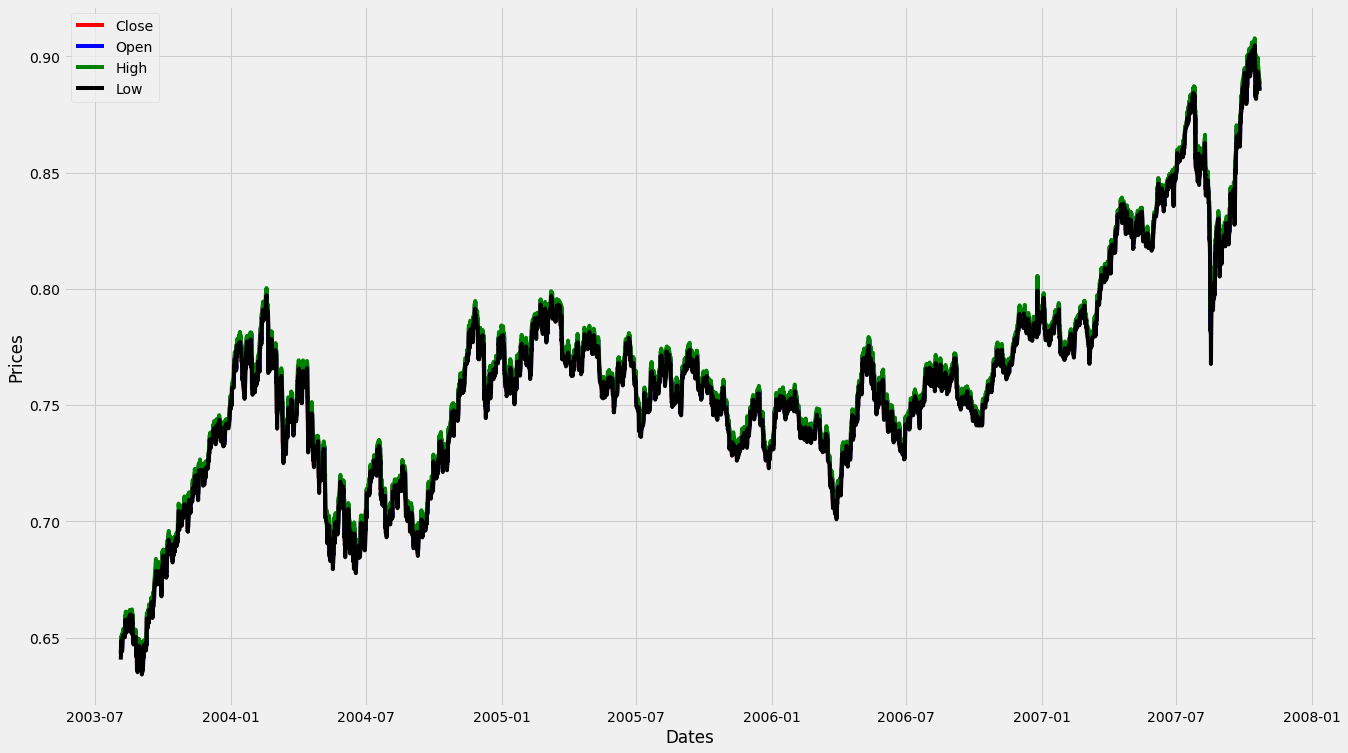

In [ ]:
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_aud['Close'],color='red',label='Close')
plt.plot(df_aud['Open'],color='blue',label='Open')
plt.plot(df_aud['High'],color='green',label='High')
plt.plot(df_aud['Low'],color='black',label='Low')
#plt.plot(df_aud['Adj_Volume'],color='red')
plt.legend(loc='best')
plt.show()

Certain large spikes in volume in 2004, 2008 and 2020

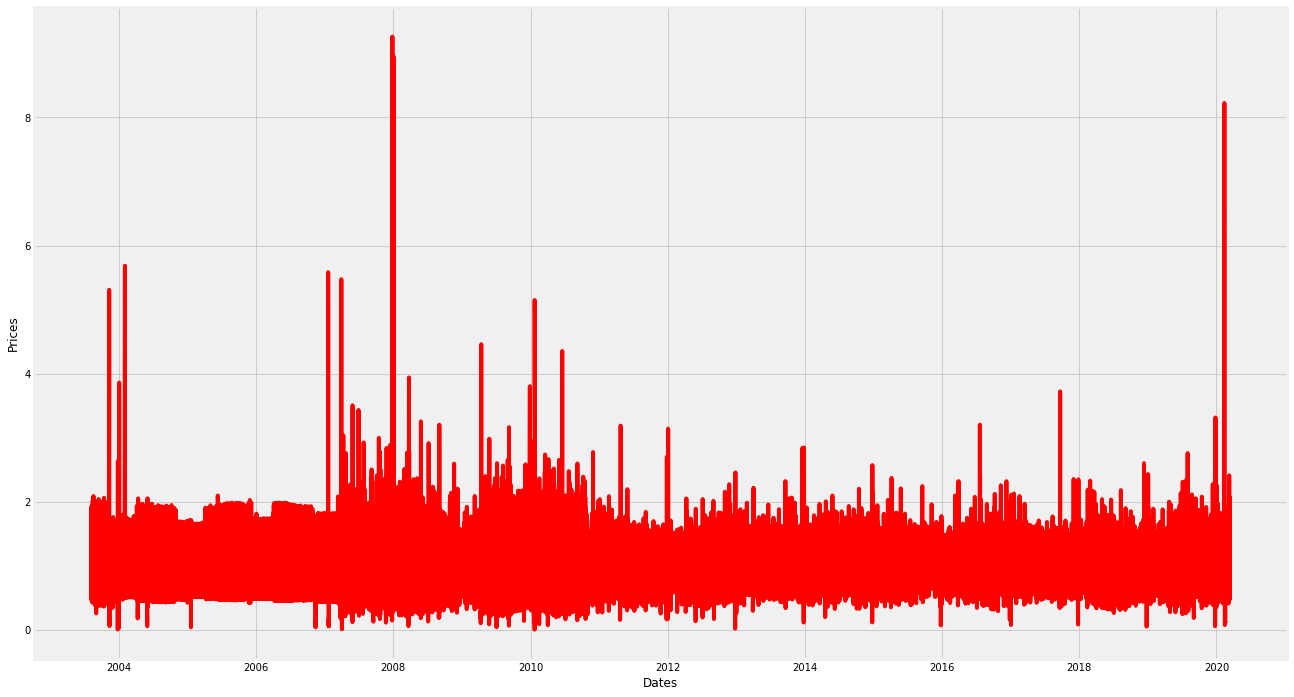

In [ ]:
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')

plt.plot(df_aud['Adj_Volume'],color='red',label='Adj_Volume')

Comparison of the distribution of absolute close values and the adjusted ones.
R_Close is evenly distributed about the mean and ready for training.

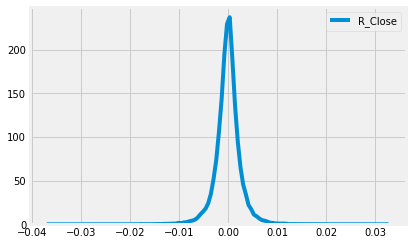

In [ ]:
dist1 = sns.kdeplot(df_aud['R_Close'])


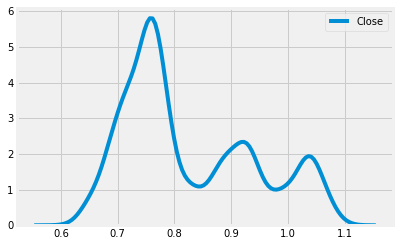

In [ ]:
dist2 = sns.kdeplot(df_aud['Close'])

Close values take a major change in between 2008 and 2009 as displayed in the trend.

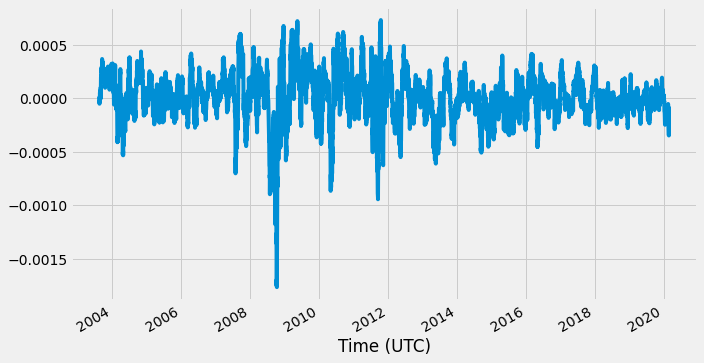

In [ ]:
result = seasonal_decompose(df_aud['R_Close'], model='additive',freq = 132).trend
fig = plt.figure()  
fig = result.plot()  

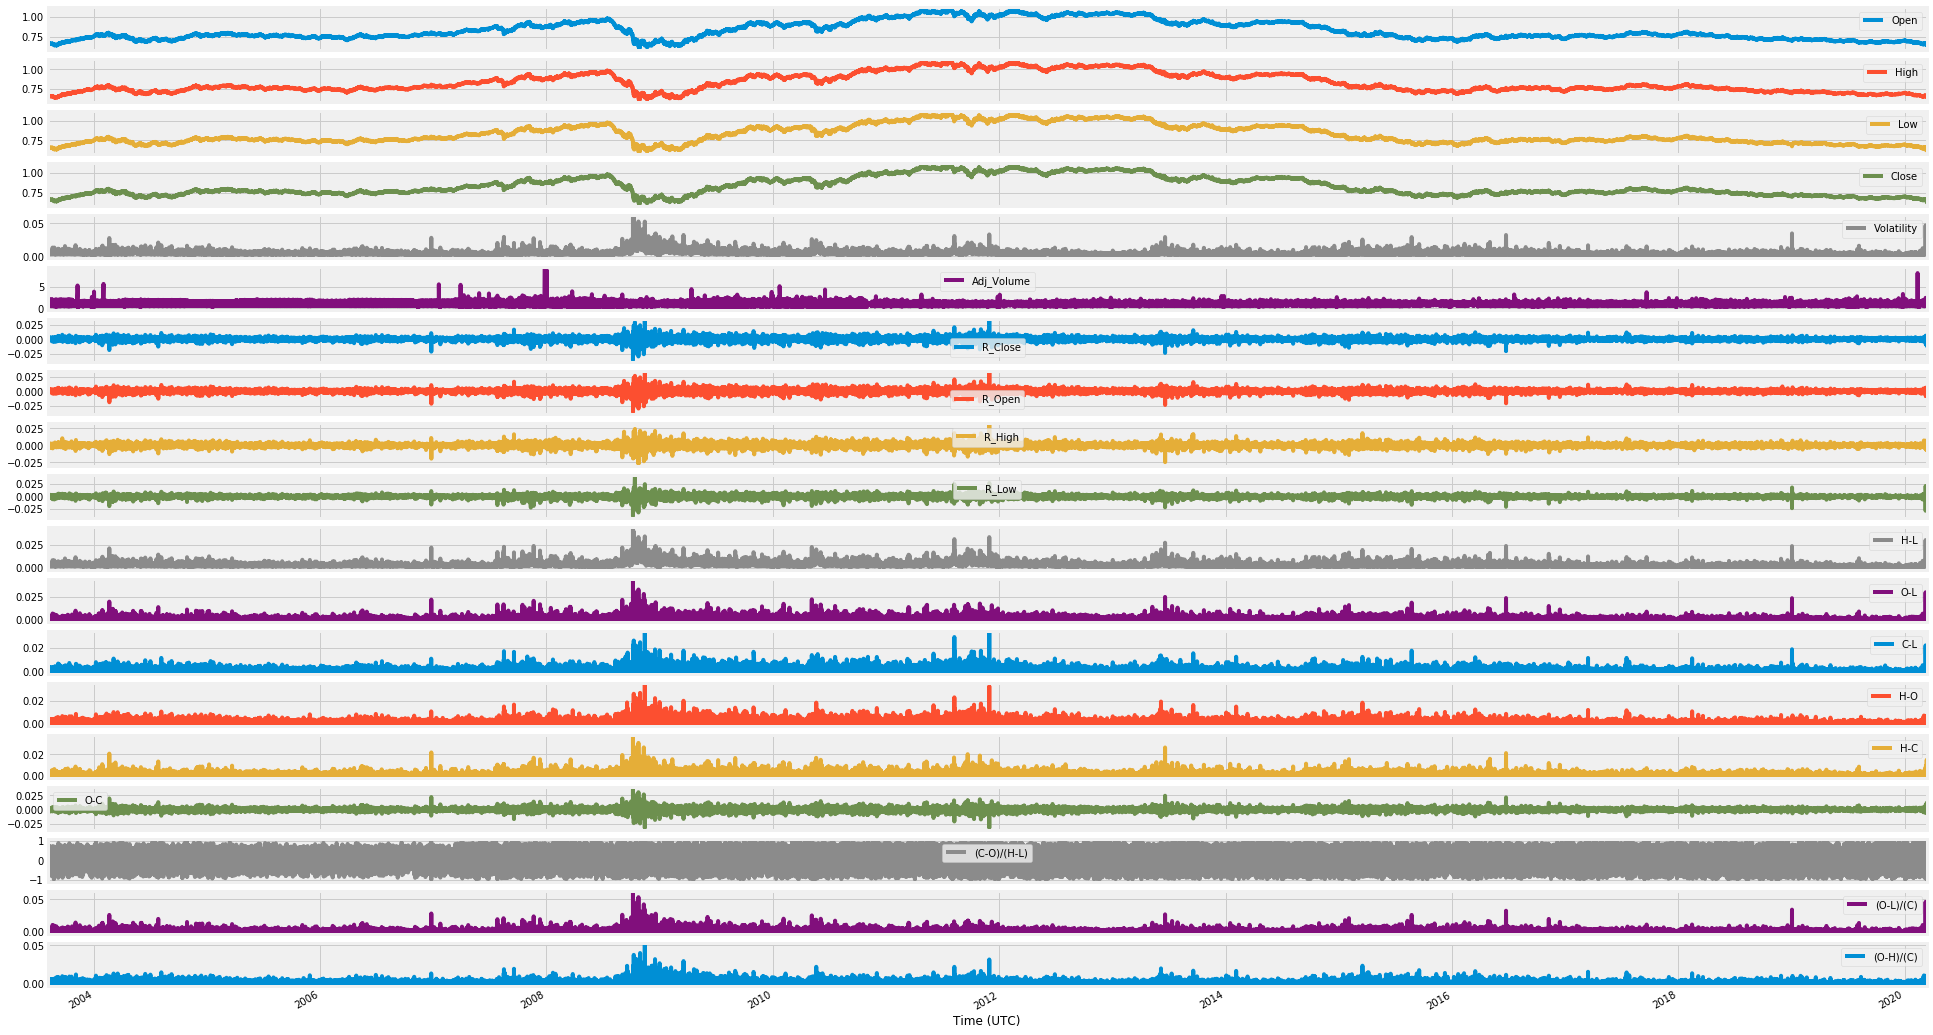

In [ ]:
figure = df_aud.plot(subplots=True,figsize=(30,20))


The below function performs the windowing task - it samples the past observation based on the step size given

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

We have to standardize the dataset using the mean and standard deviation of the training data.

In [35]:
future_target = 1
past_history = 180
STEP = 6
TRAIN_SPLIT = int(0.9*len(df_aud))
dataset = df_aud.drop(['Close','High','Low','Open','R_Close'],axis=1).values
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
d_close = df_aud.R_Close.values

Splitting of data into training and validation tests

In [36]:
x_train_single, y_train_single = multivariate_data(dataset, d_close, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP)

x_test_single, y_test_single = multivariate_data(dataset, d_close,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP)

print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (30, 14)


In [37]:
import tensorflow as tf
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(10000).batch(256).repeat()

test_data_single = tf.data.Dataset.from_tensor_slices((x_test_single, y_test_single))
test_data_single = test_data_single.batch(256).repeat()

In [13]:
def create_time_steps(length):
  return list(range(-length, 0))

LSTM Model described below

In [17]:
print("final shape of x, y train/test {} {} {} {}".format(x_train_single.shape, y_train_single.shape, x_test_single.shape, y_test_single.shape))


final shape of x, y train/test (23039, 30, 15) (23039, 1) (2399, 30, 15) (2399, 1)


In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    print(y_true)
    print(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [38]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')

In [39]:
for x, y in test_data_single.take(4):
  print(single_step_model.predict(x).shape)

(256, 1)
(256, 1)
(256, 1)
(256, 1)


In [40]:
single_step_history = single_step_model.fit(train_data_single, epochs=20,
                                            steps_per_epoch=2,
                                            validation_data=test_data_single,
                                            validation_steps=50)

Epoch 1/20
2/2 [==============================] - 0s 211ms/step - loss: 0.0934 - val_loss: 0.0016
Epoch 2/20
2/2 [==============================] - 0s 69ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 3/20
2/2 [==============================] - 0s 69ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/20
2/2 [==============================] - 0s 70ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/20
2/2 [==============================] - 0s 70ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 6/20
2/2 [==============================] - 0s 69ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/20
2/2 [==============================] - 0s 69ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 8/20
2/2 [==============================] - 0s 67ms/step - loss: 9.8500e-04 - val_loss: 0.0016
Epoch 9/20
2/2 [==============================] - 0s 66ms/step - loss: 8.4721e-04 - val_loss: 9.0415e-04
Epoch 10/20
2/2 [==============================] - 0s 71ms/step - loss: 7.9913e-04 - val_loss: 8.5537e-04
Epoch 11

In [41]:
#function to plot training and validation loss
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [42]:
#function to plot original 180 values and plot the next predicted value 
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

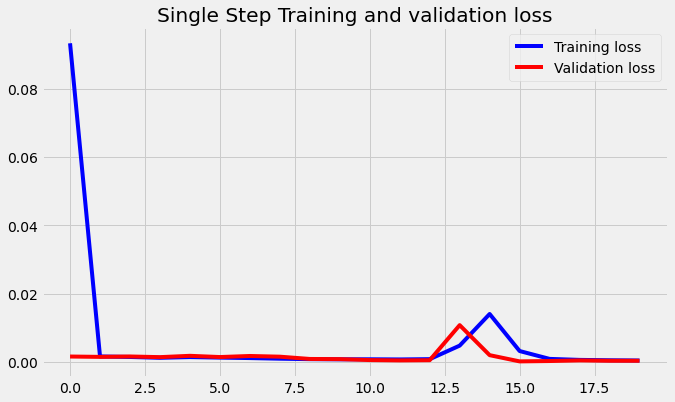

In [43]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

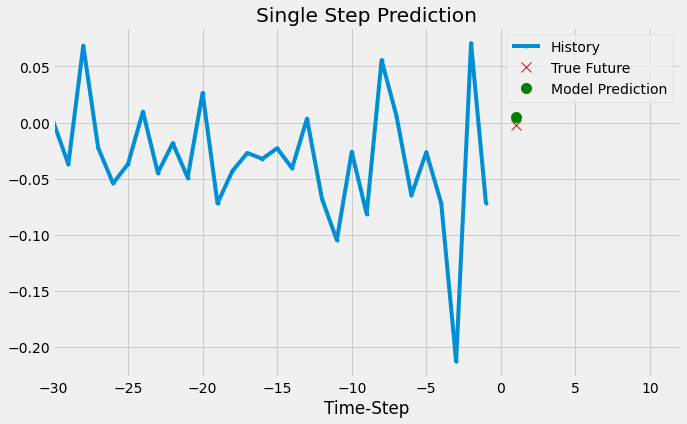

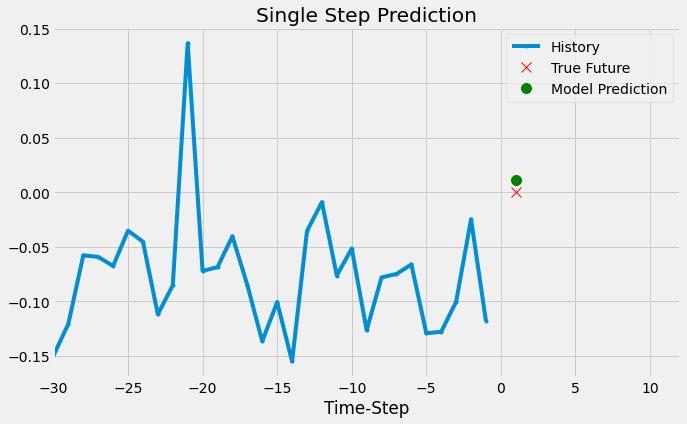

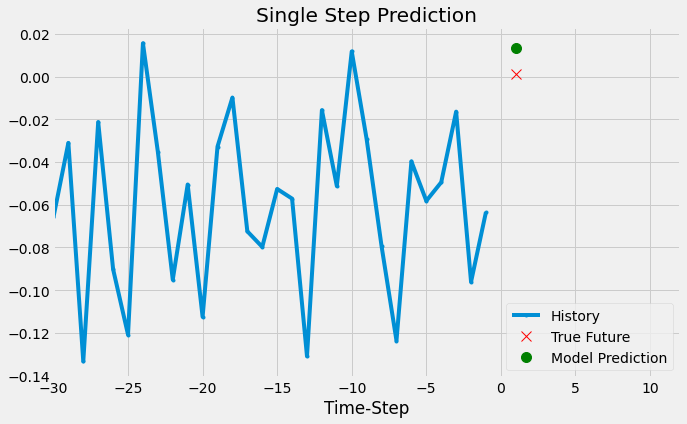

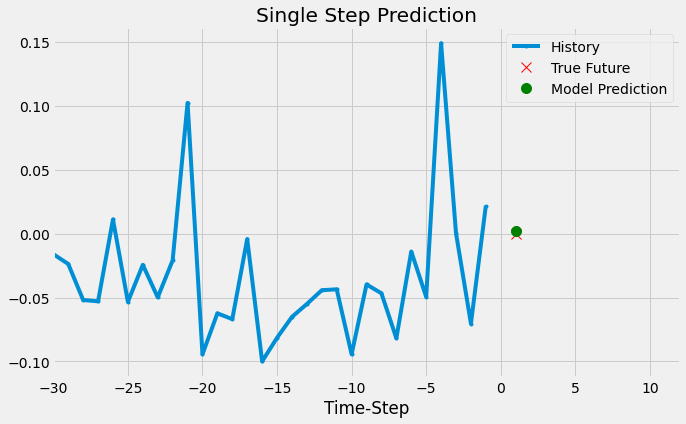

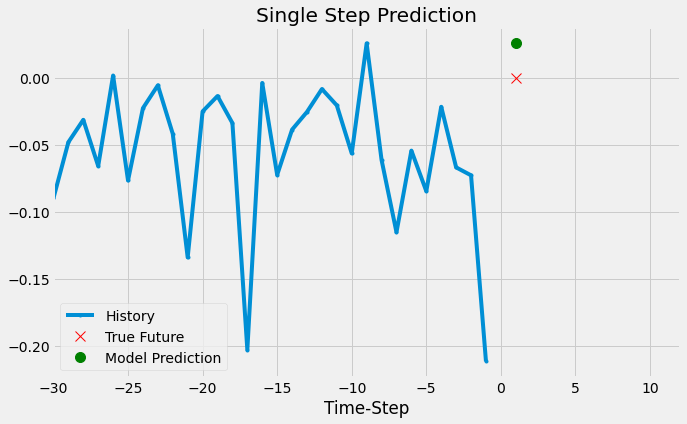

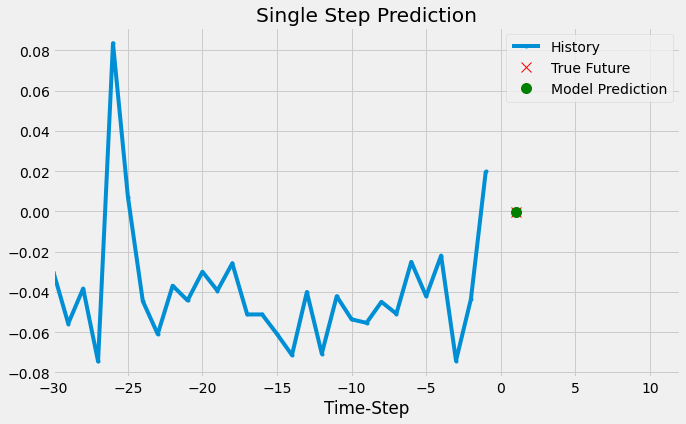

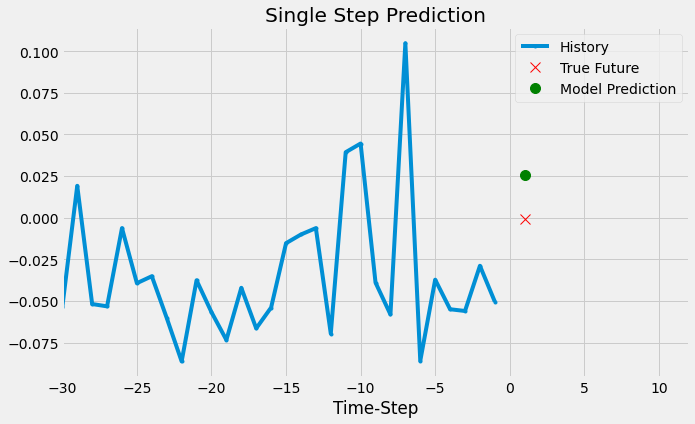

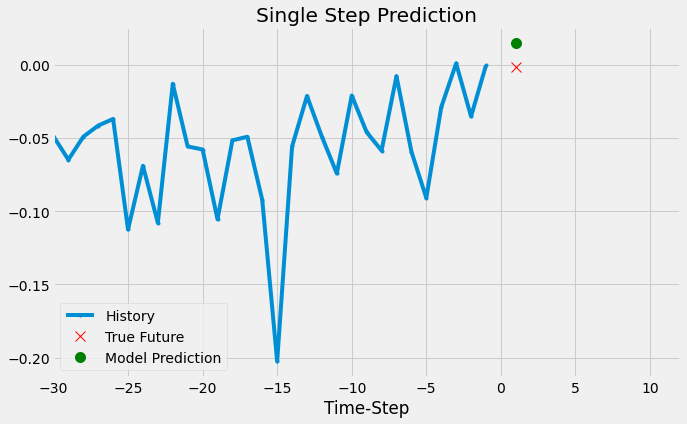

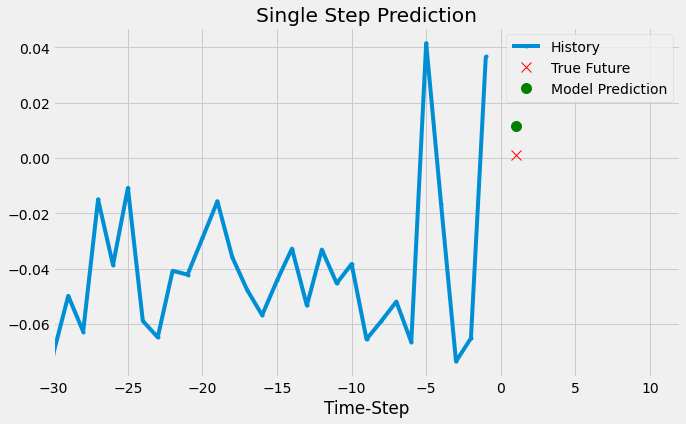

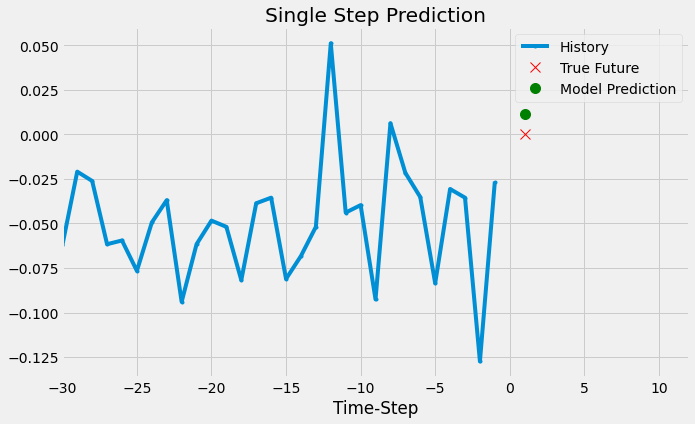

[array([-0.00178]), array([0.00043]), array([0.00106]), array([-4.e-05]), array([-0.00012]), array([-0.00039]), array([-0.00056]), array([-0.00134]), array([0.00109]), array([0.00039])]
[array([0.00502675], dtype=float32), array([0.01142668], dtype=float32), array([0.01362364], dtype=float32), array([0.00200604], dtype=float32), array([0.02582096], dtype=float32), array([-0.00011257], dtype=float32), array([0.02585292], dtype=float32), array([0.01481395], dtype=float32), array([0.0116869], dtype=float32), array([0.01121648], dtype=float32)]
MSE: 0.000219
MAE: 0.012262
MAPE:  40.599047176847634


In [47]:
expected = []
predictions = []
for x, y in test_data_single.take(10):

  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  expected.append(y[0].numpy())
  predictions.append(single_step_model.predict(x)[0])
  plot.show()

mse = mean_squared_error(expected, predictions)
mae = mean_absolute_error(expected, predictions)
mape = mean_absolute_percentage_error(expected,predictions)
print('MSE: %f' % mse)
print('MAE: %f' % mae)
print('MAPE: ', mape)

The lower the Mean Absolute Error is, the model shows that it is rightly fitted to the data.